## 问答

抛出几个Attention is all you need细节上的问题，搞明白了这几个问题，这篇论文也就理解透了：
* Position encoding细节？
* d_model和d_embedding一定相同吗？
* encoder是挨个词进去还是直接进去一个矩阵？
* Multi-head Attention 细节，d_k是什么？
* decoder底层self-attention layer为什么要mask？
* decoder的shifted right？
* decoder的具体训练过程？是否可以并行？它的input是挨个词还是直接进去一个矩阵？
* encoder和decoder句子长度不一样时，encoder-decoder attention的shape细节？

欢迎带着上述问题来读我们的blog: [论文笔记]Attention is All You Need

作者：zack
链接：https://www.zhihu.com/question/61077555/answer/526165375
来源：知乎
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

#### d_model和d_embedding一定相同吗？
不用，因为在muti-head-attention的时候，是先对输入的token（embedding形式）进行全连接操作，然后再split，然后再scaled-dot-product attention,
可以在全连接的时候，将embedding维度输出d_model维度

#### encoder是挨个词进去还是直接进去一个矩阵？
直接进去一个矩阵吧

#### Multi-head Attention 细节，d_k是什么？
dk是K的最后一个维度d_model的长度dk
假设q和k都是均值为0方差为1，可以确定的是q和k的最后一个维度都等于dk，那么他们点乘之后的结果是均值为0，方差为dk。有一种缩放方法叫做“z-score标准化”，它可以将数据转化为均值为0方差为1的分布,其中mu和sigama代表样本的均值和标准差，所以论文中的缩放就是先减去均值0，然后除以标准差根号下dk

#### decoder底层self-attention layer为什么要mask？
https://zhuanlan.zhihu.com/p/47812375

# 正式开讲
# Transformer model for language understanding
[官方源码](https://github.com/tensorflow/docs/blob/r2.0rc/site/en/r2/tutorials/text/transformer.ipynb)

This tutorial trains a Transformer model to translate Portugues to English <br>

The core idea behind the Transformer model is self-attention ——the ability to attend to different positions of the input sequence to compute a representation of that sequernce. Transformer creates stacks of self-attention layers and is explained below in the sections Scaled dot product attention and Multi-head attention.<br>

Transformer的核心是self-attention——它可以关注输入序列的不同位置，从而计算出输入序列新的表示。Transformer创建了由多个self-attention层，下面将在Scaled dot product attention 和 Multi-head attetnion 部分进行解释。<br>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipline
this dataset contains approximately 50000 training examples, 1100 validation examples and 2000 test examples.

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

W0924 14:24:58.656902 61844 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Create a custom subwords tokenizer from the training dataset

In [3]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.<br>
如果单词没有在词典里，则会把单词拆开成子单词进行编码

In [6]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target<br>
在输入、输出文本添加“开始”“结束”单词

In [8]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

To keep this example small and relatively fast, drop examples with a length of over 40 tokens.<br>
为了让数据量小些和相对快一些，我们将长度超过40的句子直接丢掉

In [9]:
MAX_LENGTH = 40
def filter_max_length(x,y,max_length = MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                         tf.size(y) <= max_length)

In [10]:
def tf_encode(pt,en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

生成最终的id化的训练数据、验证数据。进行数据预处理，比如讲单词编码为字典编号、将过长句子直接丢掉、shuffle、padding<br>
* padded_batch:当序列具有不同长度时，允许你将不同shape的tensors进行batch，每个batch内的序列都会被填充到batch内最长序列的长度

In [11]:
train_dataset = train_examples.map(tf_encode)
trian_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

In [12]:
pt_batch, en_batch = next(iter(val_dataset))
# pt_batch shape (batch_size, max_sequence_length)
pt_batch, en_batch

W0924 14:28:14.538822 19896 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0924 14:28:14.547809 19896 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0924 14:28:14.557807 19896 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0924 14:28:14.563811 19896 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0924 14:28:14.566806 14200 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


(<tf.Tensor: id=311422, shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]], dtype=int64)>,
 <tf.Tensor: id=311423, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]], dtype=int64)>)

## Positional encoding
positional encoding is added to give the model some information about the relative position of the words in the sentence <br>

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.<br>

位置编码向量会被添加到词向量。词向量代表一个单词在d维度空间的表示，意思越相近的单词，他的词向量会越接近。但是词向量无法反应两个单词的位置相关性。添加位置编码后，意思相近或者位置接近的单词，他们在d维度空间也会越接近。<br>

The formula for calculationg the positional encoding is as follows:
$$\\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

* 为每个位置随机初始化一个向量，在训练过程中更新这个向量；
* 《Attention is All You Need》使用正弦函数和余弦函数来构造每个位置的值。

https://kexue.fm/archives/4765

1、以前在RNN、CNN模型中其实都出现过Position Embedding，但在那些模型中，Position Embedding是锦上添花的辅助手段，也就是“有它会更好、没它也就差一点点”的情况，因为RNN、CNN本身就能捕捉到位置信息。但是在这个纯Attention模型中，Position Embedding是位置信息的唯一来源，因此它是模型的核心成分之一，并非仅仅是简单的辅助手段。

2、在以往的Position Embedding中，基本都是根据任务训练出来的向量。而Google直接给出了一个构造Position Embedding的公式：


这里的意思是将id为p的位置映射为一个dpos维的位置向量，这个向量的第i个元素的数值就是PEi(p)。Google在论文中说到他们比较过直接训练出来的位置向量和上述公式计算出来的位置向量，效果是接近的。因此显然我们更乐意使用公式构造的Position Embedding了。

3、<b>Position Embedding本身是一个绝对位置的信息</b>，但在语言中，相对位置也很重要，Google选择前述的位置向量公式的一个重要原因是：由于我们有sin(α+β)=sinαcosβ+cosαsinβ以及cos(α+β)=cosαcosβ−sinαsinβ，这表明位置p+k的向量可以表示成位置p的向量的线性变换，这提供了表达相对位置信息的可能性。

结合位置向量和词向量有几个可选方案，可以把它们拼接起来作为一个新向量，也可以把位置向量定义为跟词向量一样大小，然后两者加起来。FaceBook的论文和Google论文中用的都是后者。直觉上相加会导致信息损失，似乎不可取，但Google的成果说明相加也是很好的方案。看来我理解还不够深刻。

还有，尽管论文给出的Position Embedding是sin,cos交错的形式，但其实这个交错形式没有特别的意义，你可以按照任意的方式重排它（比如前sin后cos地拼接），原因如下：

1、假如你的Position_Embedding是拼接到原来的词向量中，那么将cos和sin前后连接还是交叉连接，都是没区别的，因为你下一步都是接一个变换矩阵而已；

2、如果你的Position_Embedding是加到原来的词向量中，那么两种方式貌似是有点区别的，但是要注意的是，词向量本身没有局部结构，也就是说，50维的词向量，将每一维打乱重新排个序（当然整体要按同样的顺序来重新排序），它还是等价于原来的词向量。既然相加的对象（词向量）都没有局部结构，我们也没必要强调被加的对象（Position_Embedding）的局部结构（也就是交叉连接）了。

In [13]:
# parm: pos is 编码id
# parm: i is 这个编码id对应的d_model个数组成的list
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [14]:
# parm:position is vocab_size，对每一个编码id进行处理
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

纵坐标是位置，给定一共有50个位置（max_seq_length=50）

横坐标是每个位置的维度，等于每个单词的维度，最后两者要直接相加

(1, 50, 512)


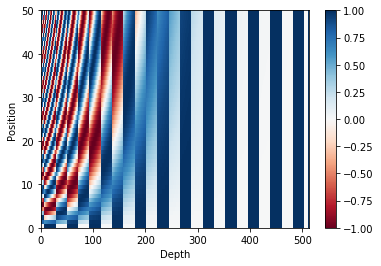

In [15]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking
Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

标1说明这个位置不会被用

creat_padding_mask方法适用于对encoder中的输入进行mask

In [16]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [17]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=311439, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence.<b> In other words, the mask indicates which entries should not be used.</b>

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

标1说明这个位置不会被用

creat_padding_mask方法适用于对decoder中的输入进行mask

In [18]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [19]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=311455, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

##  Scaled dot product attention

![](./img/dot_product_attention.png)
The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$
The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. Hence, square root of dk is used for scaling (and not any other number) because the matmul of Q and K should have a mean of 0 and variance of 1, and you get a gentler softmax.

<b>例如，假设Q和K的均值为0，方差为1。它们的矩阵乘法的均值为0，方差为dk。因此，dk的平方根用于缩放(而不是其他任何数)，因为Q和K的matmul的均值应该是0，方差应该是1，这样就得到了一个更温和的softmax。</b>


The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

掩码乘以-1e9(接近负无穷)。之所以这样做，是因为掩码是由Q和K的缩放矩阵乘法求和的，并且应用于softmax之前。目标是使这些单元格归零，而softmax的大量负输入在输出中接近于零。



### 关于scaled(缩放)的补充
scaled dot-product attention 和 dot-product attention 唯一的区别就是，scaled dot-product attention 有一个缩放因子dk，表示 Key 的维度，默认用 64。

论文里对于 dk 的作用这么来解释：对于 dk 很大的时候，<b>点积得到的结果很大</b>，使得结果处于<b>sfotmax函数</b>梯度很小的区域（也就是激活函数的饱和区）。这时候除以一个缩放因子，可以一定程度上减缓这种情况。

### 为什么点积得到的结果很大呢？

论文中有一段解释：To illustrate why the dot produces get large, assume that the componnents of q and k are independent random variables
 with mean 0 and variance 1. Then their dot product,has mean 0 and variance dk. 

假设q和k都是均值为0方差为1，他们点乘之后的结果是均值为0，方差为dk。 $$q \cdot k=\sum_{i=1}^{d_{k}} q_{i} k_{i}$$


有一种缩放方法叫做“z-score标准化”，它可以将数据转化为均值为0方差为1的分布,其中mu和sigama代表样本的<b>均值和标准差</b>，所以论文中的缩放就是先减去均值0，然后除以标准差根号下dk
$$\frac{X_{i}-\mu}{\sigma}$$

### 一篇文章中有 Layer Normalization的介绍
https://zhuanlan.zhihu.com/p/47812375

对Normalization 有很多种，但是它们都有一个共同的目的，那就是<b>把输入转化成均值为 0 方差为 1 的数据</b>。我们<b>在把数据送入激活函数之前进行 normalization（归一化）</b>,为我们不希望输入数据落在<b>激活函数的饱和区。</b>

说到 normalization，那就肯定得提到 Batch Normalization。

BN 的主要思想就是：在每一层的每一批数据上进行归一化。我们可能会对输入数据进行归一化，但是经过该网络层的作用后，我们的数据已经不再是归一化的了。随着这种情况的发展，数据的偏差越来越大，我的反向传播需要考虑到这些大的偏差，这就迫使我们只能使用较小的学习率来防止梯度消失或者梯度爆炸。

BN 的具体做法就是对每一小批数据，在批这个方向上做归一化。

In [20]:
def scaled_dot_product_attention(q,k,v,mask):
    '''calculate the attention weights.
    q, k, v must have matching leading(领先的) dimensions
    k, v must have matching penultimate(倒数第二) dimension, ie: seq_len_k = seq_len_v
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.
    
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k).Defaults to None.
    '''
    matmul_qk = tf.matmul(q,k,transpose_b=True) #(..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add the mask to the scaled tensor 
    # 要在scaled_attention_logits最后一维上添加1*-1e9
    # 此时的scaled_attention_logits的维度是(batch_size,num_heads,seq_len_q,seq_len_k),所以mask的维度应该是(batch_size, 1, 1, seq_len_k),也可以看出mask对应的是key的seq_len
    # 我们应该对key进行求mask
    # mask * -1e9  == -10000000000，加在原有的logits值上也是一个很小的值
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1
    attention_weights = tf.nn.softmax(scaled_attention_logits,axis = -1) #(..,seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v) #(..., seq_len_q, depth_v)
    
    return output, attention_weights

### mask
\#add the mask to the scaled tensor 

要在scaled_attention_logits最后一维上添加1*-1e9, 此时的scaled_attention_logits的维度是(batch_size,num_heads,seq_len_q,seq_len_k),所以mask的维度应该是(batch_size, 1, 1, seq_len_k), 也可以看出mask对应的是key的seq_len, 因为QK之后输出维度是(batch_size,num_heads,seq_len_q,seq_len_k)，输出维度最后一个是seq_len_k.

mask * -1e9  == -10000000000，加在原有的logits值上也是一个很小的值

在decoder中第二个sclaed dot product attention中，mask也是根据encoder中的输入产生的，因为encoder的output(batchsize, seq_len, d_model)在这个attention中充当k的角色，attention中的mask也要以key的seq_len_k为准，因为scaled_attention_logits的维度是(batch_size,num_heads,seq_len_q,seq_len_k)
### 输出attention_weights (..,seq_len_q, seq_len_k)
计算attention_weights时，softmax 是在最后一个维度（seq_len_k）做处理,使得这个维度加起来之和等于1，attention_weights的维度依然等于acaled_attention_logits的维度

### 输出output (..., seq_len_q, depth_v)

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [58]:
def print_out(q,k,v):
    temp_out, temp_attn = scaled_dot_product_attention(q,k,v,None)
    print("Attention weights are:")
    print(temp_attn)
    print("Output is:")
    print(temp_out)

In [22]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]],dtype=tf.float32) #(4,3)

temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]],dtype=tf.float32) #(4,2)

temp_q = tf.constant([[0,10,0]],dtype=tf.float32) #(1,3)

print_out(temp_q,temp_k,temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


## Multi-head attention

![](./img/MultiHeadAttention.png)
Multi-head attention consists of four parts:

* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

之所以把Q\K\V分割到多个头中而不是一个attention head中，是因为这样会允许模型注意到不同位置的信息。分割到不同的头会使得减小维度。这样总的计算量与之前只分配到一个头是一样的。

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads==0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        '''Split the last dimention into (num_heads, depth).
        Transpose the result such that the shpe is (batch_size, num_heads, seq_len, depth)
        '''
        x = tf.reshape(x,(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x,perm=[0,2,1,3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # 在scaled_dot_product_attention中，只会改变计算q\k\v的最后两个维度
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q,k,v,mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

### 输出 attention_weights : (batch_zise, num_heads, seq_len_Q, seq_len_K)
### 输出 output : (batch_size, seq_len_Q, depth_V)

Create a MultiHeadAttention layer to try out. At each location in the sequence, y, the MultiHeadAttention runs all 8 attention head across all other location in the sequence, returning a new vector of the same length at each location

In [24]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network
Point wise feed forward network consists of two fully-connected layers with a ReLU activation in bettween.

In [25]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [26]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder
![](./img/decoderEncoder.png)

The transformer model follows the same general pattern as a standard sequence to sequence with attention model.

* The input sentence is passed through N encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.


### Encoder layer
Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask)

2. Point wise feed forward networks.

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

每个子层周围都有一个残差连接，然后进行层标准化。在深度网络中，残差连接有助于避免梯度消失问题。

The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis. There are N encoder layers in the transformer.

在LayerNorm(x + Sublayer(x))中，Sublayer是我们的muti-head-attention的处理结果，x是残差连接，不对x做任何处理，对x + Sublayer(x) 进行normalization

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _  = self.mha(x, x, x, mask) #(batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        # normalization中考虑到残差处理
        out1 = self.layernorm1(x+attn_output) #(batch_size, input_seq_lenm, d_model)
        
        ffn_output = self.ffn(out1) #(batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

In [28]:
sample_encoder_layer = EncoderLayer(512, 8, 20435)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64,43,512)), False, None)
sample_encoder_layer_output.shape #(batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## Decoder layer
Each decoder layer consists of sublayers:
1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention(with padding mask). V(value) and K(key) receive the encoder output as inputs.Q(query) receives the output from the masked multi-head attention sublayer.
3. Point wise feed forward nerworks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)) . The normalization is done on the d_model(last) axis.

There ate N dicoder layers in the transformer.

As Q receive the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attentding to its own output. See the demonstration above in the scaled dot product attention section.

decoder layer中：<br>
* Q 是decoder第一层attention block的输出<br>
* K和V是encoder的输出<br>
* attention weights 代表decoder的输入与encoder的输出的相关性<br>
* 换句话说，decoder预测下一个单词，是靠encoder的输出和自身self-attention的输出<br>

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) #(batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        # 加上未经过attetion层的x(Query)，是进行残差处理，防止梯度消失
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask) #(batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2) #(batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) #(batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [44]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, block1, block2 = sample_decoder_layer(
    tf.random.uniform((64,50,512)),sample_encoder_layer_output,False,None,None)

print(sample_decoder_layer_output.shape) #(batch_size, target_seq_len, d_model)
print(block1.shape) # (batch_size, num_heads, target_seq_len, seq_len_k),k是decoder的输入自身
print(block2.shape) # (batch_size, num_heads, target_seq_len, seq_len_k),k是encoder的输出output长度,也就是input_seq_len

(64, 50, 512)
(64, 8, 50, 50)
(64, 8, 50, 43)


## Encoder

The Encoder consist of :
1. Input Embedding
2. Positionam Encoding
3. N encoder layers

The input is put through an embedding which is summed with the positionam encoding. The optput of this summation is the input to the encoder layers. The output of the encoder os the input to the decoder.

In [31]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x) #(batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x # (batch_size, input_seq_len, d_model)

In [32]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500)

sample_encoder_output = sample_encoder(tf.random.uniform((64,62)),training=False, mask=None)

print(sample_encoder_output.shape) #(batch_size, input_seq_len, d_model)

(64, 62, 512)


## Decoder
The Decoder consists of:
1. Output Embedding
2. Positional Encoding
3. N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final liner layer.

In [45]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:,:seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights["decoder_layer{}_block1".format(i+1)] = block1
            attention_weights["decoder_layer{}_block2".format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    

In [46]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000)

output, attn = sample_decoder(tf.random.uniform((64,26)),enc_output=sample_encoder_output,training=False,look_ahead_mask=None,padding_mask=None)

output.shape, attn["decoder_layer2_block2"].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer
Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [48]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, rate)
        
        # 预测下一个单词
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        
        # enc_output.shape == (batch_size, inp_seq_len., d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask) 
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
        

In [50]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64,62))
temp_target = tf.random.uniform((64,26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                                enc_padding_mask=None,
                                look_ahead_mask=None,
                                dec_padding_mask=None)

fn_out.shape #(batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

## Set hyperparameters
To keep this example small and relatively fast, the values for num_layers, d_model, and dff have been reduced.

The values used in the base model of transformer were; num_layers=6, d_model = 512, dff = 2048. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [51]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in [paper](https://arxiv.org/abs/1706.03762) 
$$\text {lrate}=d_{\text {model}}^{-0.5} * \min \left(\text {step}_{-} \text {num }^{-0.5}, \text { step }_{-} \text {num } * \text { warmu } p_{-} \text {ste ps }^{-1.5}\right)$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1,arg2)

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

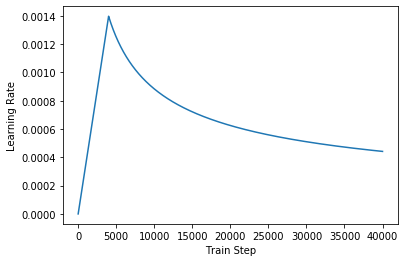

In [54]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

## Training and checkpointing

In [55]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                            input_vocab_size, target_vocab_size, dropout_rate)

In [56]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder
    # This padding mask is used to mask the encoder outputs
    dec_padding_mask = create_padding_mask(inp)
    
    # Used in the 1st attention block in the decoder
    # It is used to pad and mask future tokens in the input receives by the decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [57]:

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. tar_real is that same input shifted by 1: At each location in tar_input, tar_real contains the next token that should be predicted.

For example, sentence = "SOS A lion in the jungle is sleeping EOS"

tar_inp = "SOS A lion in the jungle is sleeping"

tar_real = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the text generation tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)